## Computation HW #3 - April 1

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.table import Table
import random
import time
from scipy.spatial import KDTree
from sklearn.cluster import MiniBatchKMeans
from pyro import Pyro

# translates python code into machine code to go faster
from numba import jit

from cycler import cycler
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rc('axes',prop_cycle=(cycler('color', ['#003a7d','#d83034','#98c127','#f9e858','#ff9d3a','#008dff', '#ff73b6', '#c701ff'])))

## Question 1

In [143]:
# Caclulates acceleration of random particles in three dimensions due to gravity
# INPUT: npart x 3 length array of x,y,z coordinates of particles
# RETURNS: total force on particles in x,y,z directions
# note: instead of doing two full for-loops, we use the fact that force on particle a from b = negative force on particle b from a
@jit
def direct_accel(rand_vec):
    
    num_part = len(rand_vec)

    # Equal to acceleration since using unit masses
        # This naming makes more sense in my brain
    forces_x = np.zeros(num_part)
    forces_y = np.zeros(num_part)
    forces_z = np.zeros(num_part)

    # Loop over each particle
    for curr_part in range(num_part):

        # Loop over remaining particles
            # already calculated force from particles earlier in array, don't need to recalculate
        for j in np.arange(curr_part+1, num_part, 1):

            # calculate force between two particles
            r = rand_vec[j] - rand_vec[curr_part]
            dist = (r[0]**2 + r[1]**2 + r[2]**2)**(1/2)
            curr_force = 1/dist**3 * r

            # save forces, using newton's third law
            forces_x[curr_part] += curr_force[0]
            forces_x[j] -= 1*curr_force[0]

            forces_y[curr_part] += curr_force[1]
            forces_y[j] -= 1*curr_force[1]

            forces_z[curr_part] += curr_force[2]
            forces_z[j] -= 1*curr_force[2]

    # divide by mass here, if not unit mass
    return forces_x, forces_y, forces_z

In [205]:
# Uses a KDTree to estimate the acceleration of particles in 3D. Calculates acceleration directly for num_direct
# treats the remaining particles in groups as one particle at COM
# INPUT: 3d vector of locations, search radius for where to stop calculating directly,
# RETURNS: acceleration of each particle in x,y,z directions

def kdtree_accel(rand_vec, num_direct, nfar_clusters=15):

    # Basic setup 
    npart = rand_vec.shape[0]
    accel = np.zeros([npart,3])
    eps = 1e-10 # softening at small distances

    # Setup tree and find nearest num_direct neighbors for each point
    tree = KDTree(rand_vec)
    dists, neighbor_idxs = tree.query(rand_vec, k=num_direct+1) # include self (so add one)

    # Estimate clusters ahead of time -- saves time in loop
    kmeans = MiniBatchKMeans(n_clusters=nfar_clusters)
    families = kmeans.fit_predict(rand_vec)
    cluster_idxs = [np.where(families == j)[0] for j in range(nfar_clusters)]
    centers = kmeans.cluster_centers_

    # Loop over particles
    for i in range(npart):

        # Get the indicies of the nearest neighbors, calculate these directly -- don't include self
        near_idx = neighbor_idxs[i]
        near_idx = np.delete(near_idx, np.where(near_idx == i)[0])

        # Directly calculate for nearby points
        neighbors = rand_vec[near_idx]
        r = neighbors - rand_vec[i]
        dist = np.sum(r**2, axis=1)**(1/2) + eps
        inv_dist = 1.0 / dist**3
        accel[i] += np.sum(r * inv_dist[:, np.newaxis], axis=0) # need to make this the same shape

        # Estimate remaining points as particle at far cluster centers -- this does re-estimate self-cluster
        for i,com in enumerate(centers):
            r = com - rand_vec[i]
            dist = (np.sum(r**2))**(1/2) + eps
            inv_dist = 1.0 / (dist ** 3)
            accel[i] += len(cluster_idxs[i]) * r * inv_dist

    return accel

In [160]:
# Driver function that calculates acceleration of particles
# INPUT: number of particles, if using direct method
#        if not directly calculating, input number of nearest neighbors to directly calculate for & number of clusters to split far points into
def calculate_accel(npar, direct=True, num_direct=100, nfar_clusters=25):

    # Make 3D position vector uniform in x,y,z
    new_randvec=my_randState.rand(npar,3)*100

    # If calculating acceleration directly
    if direct:
        start_time = time.time()
        accel_x, accel_y, accel_z = direct_accel(new_randvec)
        end_time = time.time()
        print("Time for direct method with N =", npar, ':', end_time-start_time)
        
        return [accel_x, accel_y, accel_z]

    # If estimating acceleration with KDTree
    else:
        print('Working on KDTree with', npar, 'particles')
        start_time = time.time()
        accel = kdtree_accel(new_randvec, num_direct, nfar_clusters)
        end_time = time.time()
        print("Time for KDTree method with N =", npar, ':', end_time-start_time)
        return accel

In [125]:
# Set random seed
my_randState=np.random.RandomState(seed=539271)

# Calculate direct acceleration for each N
a_3d = calculate_accel(1000)
a_4d = calculate_accel(10000)
a_5d = calculate_accel(100000)
a_6d = calculate_accel(1000000) # Takes ~14 hours! Kernel restarted

Time for direct method with N = 1000 : 1.7289988994598389
Time for direct method with N = 10000 : 2.6894261837005615
Time for direct method with N = 100000 : 267.3550183773041
Time for direct method with N = 1000000 : 47498.04906630516


In [207]:
# Calculate acceleration with KDTree for each N

a_3kd = calculate_accel(1000, direct=False, num_direct=100, nfar_clusters=25)
a_4kd = calculate_accel(10000, direct=False, num_direct=100, nfar_clusters=25)
a_5kd = calculate_accel(100000, direct=False, num_direct=100, nfar_clusters=25)
a_6kd = calculate_accel(1000000, direct=False, num_direct=100, nfar_clusters=10)

Working on KDTree with 1000 particles
Time for KDTree method with N = 1000 : 0.1654667854309082
Working on KDTree with 10000 particles
Time for KDTree method with N = 10000 : 1.5403060913085938
Working on KDTree with 100000 particles
Time for KDTree method with N = 100000 : 14.302671194076538
Working on KDTree with 1000000 particles
Time for KDTree method with N = 1000000 : 85.77979683876038


Text(0.5, 1.0, 'N=100000')

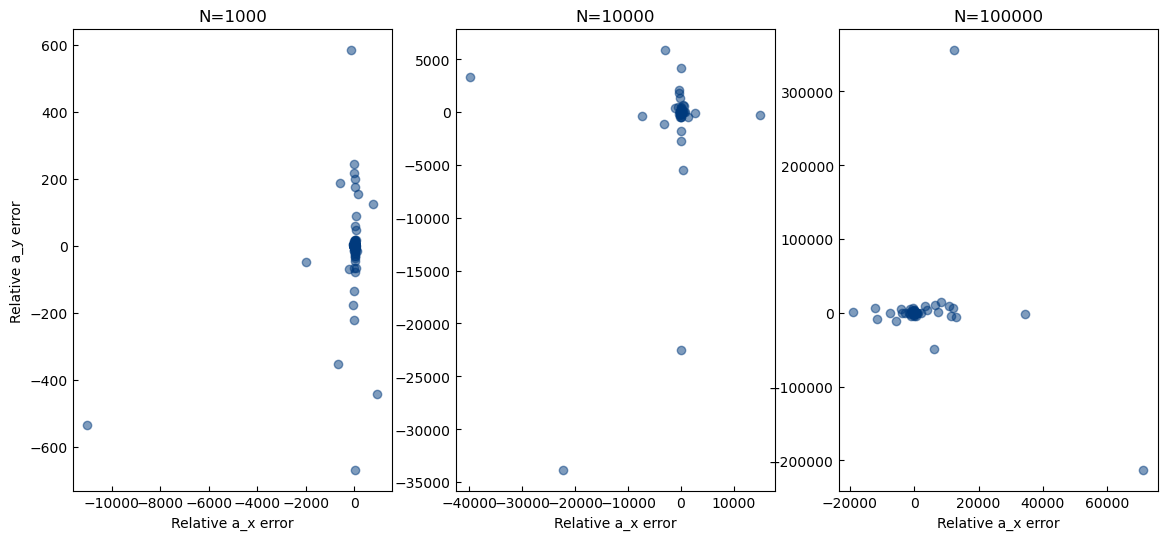

In [210]:
fig, axes = plt.subplots(1,3, figsize=(14,6))

axes[0].scatter((a_3d[0]-a_3kd[:,0])/a_3d[0], (a_3d[1]-a_3kd[:,1])/a_3d[1],alpha=0.5)
axes[1].scatter((a_4d[0]-a_4kd[:,0])/a_4d[0], (a_4d[1]-a_4kd[:,1])/a_4d[1],alpha=0.5)
axes[2].scatter((a_5d[0]-a_5kd[:,0])/a_5d[0], (a_5d[1]-a_5kd[:,1])/a_5d[1],alpha=0.5)

axes[0].set_xlabel('Relative a_x error')
axes[1].set_xlabel('Relative a_x error')
axes[2].set_xlabel('Relative a_x error')
axes[0].set_ylabel('Relative a_y error')

axes[0].set_title('N=1000')
axes[1].set_title('N=10000')
axes[2].set_title('N=100000')

It's much faster to use the KDTree method which really estimates acceleration from far away particles. This increase in speed comes at the cost of accuracy. I could increase the accuracy of the KDTree method by enusuring we don't double count particles, but it would take much longer. The timing increase is significantly shallower for the KDTree O(NlogN) method than for the direct method O(N^2).

## Question 2. 

Compressible:


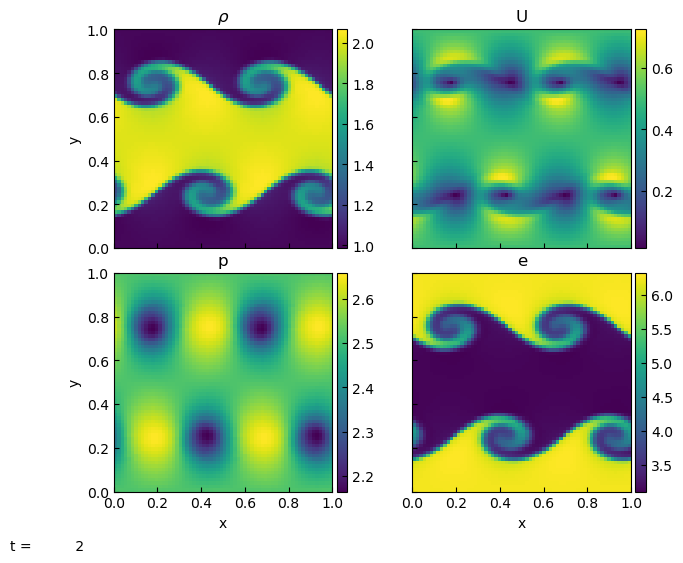

Compressible RK:


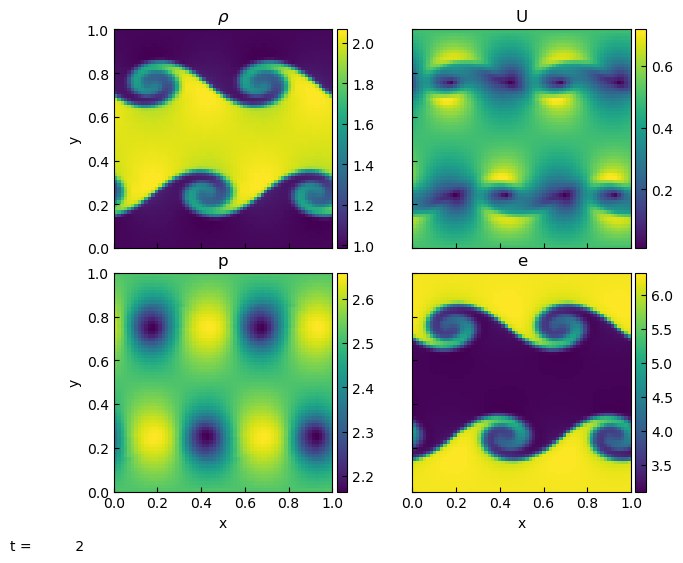

Compressible fv4:


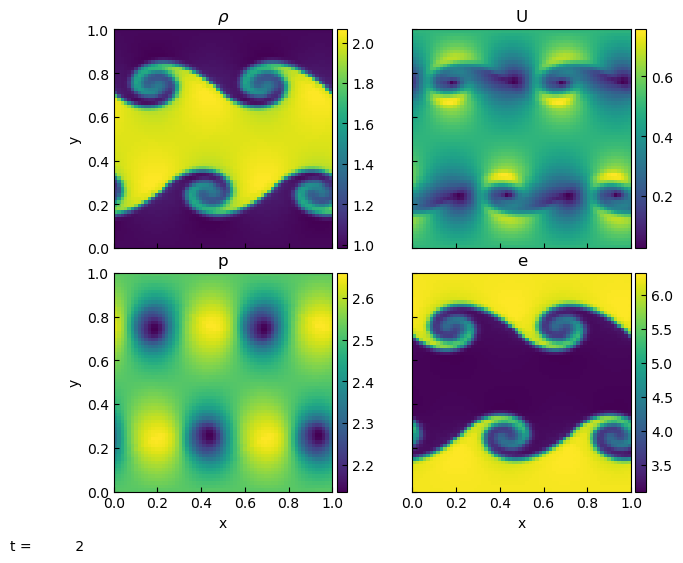

Compressible sdc:
warning, key: compressible.limiter not defined


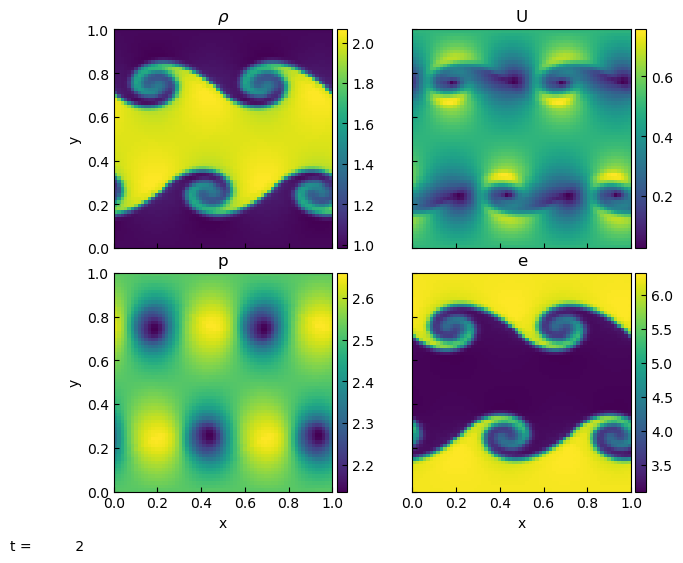

<Figure size 800x600 with 0 Axes>

In [208]:
# Kelvin-Helmholtz problem with relative velocity +- 1 (default)

print('Compressible:')
pyro_comp = Pyro("compressible") # Setup which solver we want to use
parameters = {'vis.dovis': False} # Turn off visualization at every timestep
pyro_comp.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters) 
pyro_comp.run_sim() # Run solver
pyro_comp.sim.dovis() # Show last visualization

# Repeat steps for other solvers
print('Compressible RK:')
pyro_compRK = Pyro("compressible_rk")
pyro_compRK.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_compRK.run_sim()
pyro_compRK.sim.dovis()


print('Compressible fv4:')
pyro_comp_fv4 = Pyro("compressible_fv4")
pyro_comp_fv4.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_comp_fv4.run_sim()
pyro_comp_fv4.sim.dovis()


print('Compressible sdc:')
pyro_comp_sdc = Pyro("compressible_sdc")
pyro_comp_sdc.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_comp_sdc.run_sim()
pyro_comp_sdc.sim.dovis()

Compressible:


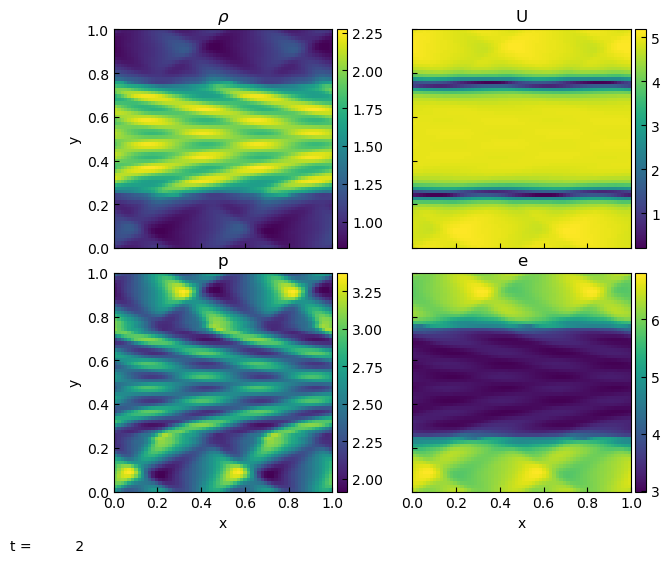

Compressible RK:


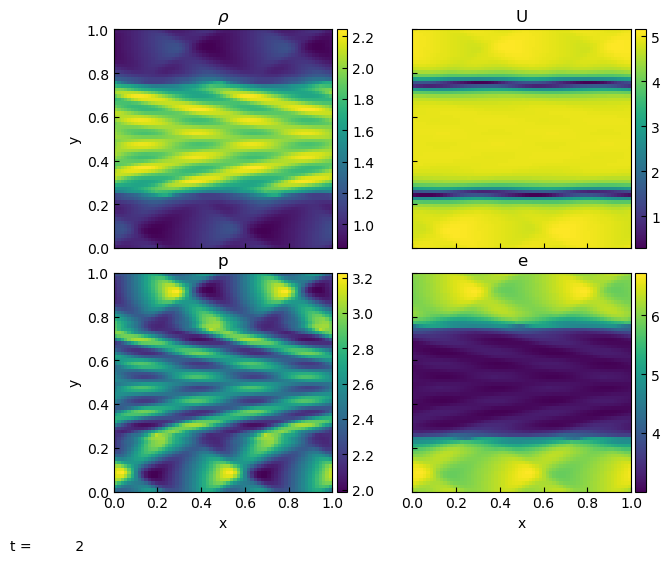

Compressible fv4:


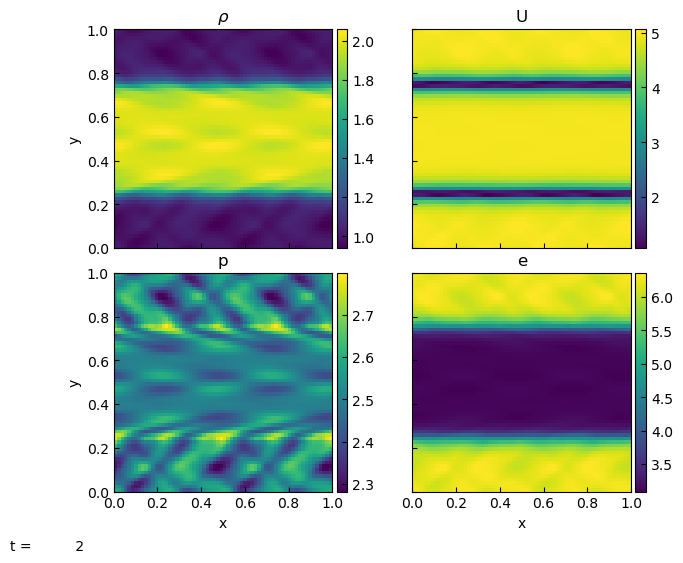

Compressible sdc:
warning, key: compressible.limiter not defined


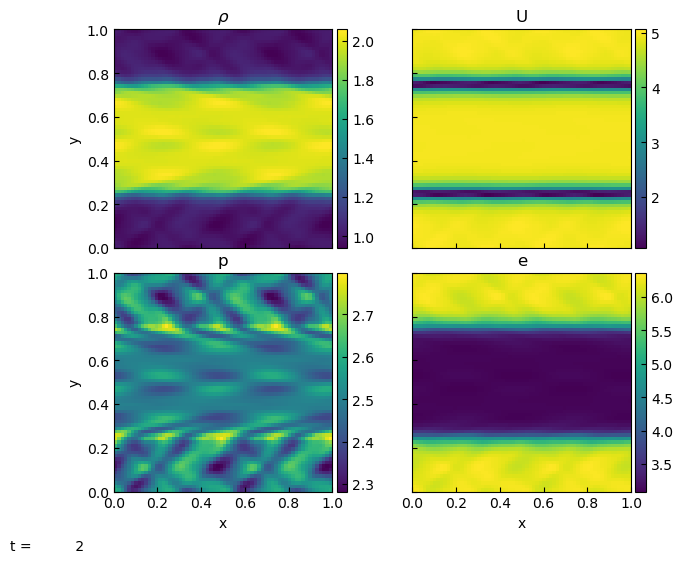

<Figure size 800x600 with 0 Axes>

In [209]:
# Repeat above but with relative velocity +- 10

print('Compressible:')
pyro_comp = Pyro("compressible")
parameters = {'vis.dovis': False, 'kh.u_1':-5., 'kh.u_2':5.} # Now, also want to change x-velocities for lighter fluid.
pyro_comp.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_comp.run_sim()
pyro_comp.sim.dovis()


print('Compressible RK:')
pyro_compRK = Pyro("compressible_rk")
pyro_compRK.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_compRK.run_sim()
pyro_compRK.sim.dovis()


print('Compressible fv4:')
pyro_comp_fv4 = Pyro("compressible_fv4")
pyro_comp_fv4.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_comp_fv4.run_sim()
pyro_comp_fv4.sim.dovis()


print('Compressible sdc:')
pyro_comp_sdc = Pyro("compressible_sdc")
pyro_comp_sdc.initialize_problem(problem_name="kh",
                        inputs_file="inputs.kh",
                        inputs_dict=parameters)
pyro_comp_sdc.run_sim()
pyro_comp_sdc.sim.dovis()

There are large differences by changing the relative velocity by an order of magnitude. By increasing the relative velocity, the resulting boundary between the two fluids is less spiral/curved and much sharper as the fluids are moving faster and have less time to mix. The differences between the four solvers are more apparent in the +-10 relative velocity images. The compressible and compressible rk solvers have similar results, and the compressible fv and compressible sdc are alike.